<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/dedupe_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable solutions to detect duplicate images

Identical images are easier to detect if identity means pixel-wise identity. We can use image hash, for instance, to encode each image and quickly compare hash values of two images. However, if we want to compare how similar two images are or whether two images are "very similar" to the point where human beings cannot tell the difference, then the problem is much harder. The latter is the working definition of "duplication" and I want to show how you can detect duplicate images.



# Problems
The first question to ask is why you want to detect duplicate images. There could be many reasons, but let me list a few reasons for machine learning purposes.

**1. Bias:** Having duplicate data means that the model will be trained more on that type of data and thus will be biased. One or more duplicate data might be Okay but if there are a lot of them, the model will fail to generalize on new data.

**2. Cost:** Each piece of data needs to be labeled manually and reviewed one way or the other. Having duplicate data means adding an unnecessary cost for data processing, storage, and computation.

**3. Noise:** Duplicate data can lead to subtle noise in the training set too if the labeling is not done consistently or correctly.

For these reasons, we want to remove as much duplicate data as possible. However, detecting and removing duplicates manually is not scalable and thus the need for a better approach.

# Other Approaches
There are a few known solutions to detect duplicates.

## 1. Image hash
Encoding each image as a hash value and then comparing hash values is a quick and easy method to check identical images. However, as you will see, this method does not work if the image is slightly altered (e.g., the image pixels are moved one pixel left). Besides, image hash only provides a binary answer: the same or not. What we need is a similarity measure.

## 2. Traditional approach
Then there are traditional approaches to detect images similarities like taking differences of pixel values, comparing histograms, calculating structural similarity index [SSIM](https://en.wikipedia.org/wiki/Structural_similarity), or [feature matching](https://medium.com/data-breach/introduction-to-feature-detection-and-matching-65e27179885d). The pros and cons of each approach is beyond the scope of the current article, but in general they are good for comparing two or a few images at a time but hard to use at a large scale.
 
## 3. Deep Learning
The third approach is to leverage Deep Learning to find duplicates: e.g., a [Siamese network](https://conferences.oreilly.com/strata/strata-eu-2018/cdn.oreillystatic.com/en/assets/1/event/267/Using%20Siamese%20CNNs%20for%20removing%20duplicate%20entries%20from%20real%20estate%20listing%20databases%20Presentation.pdf). While this approach is the most robust and can handle even rotated duplicate images, it requires the heavy lifting of training and inferencing using another neural network.


# Requirements
In light of the survey of other approaches, here are the requirements that we would like to have:

1. Similarity meausres: Instead of a single binary decision of match or non-match, we want metrics that can tell us how similar two given images are.
2. Scalable: The solution should work on two images, multiple images, and a large dataset of images.
3. Light-weight: Removing duplicates is for pre-processing training data for Deep Learning so we want the solution to be as light-weight as possible.

# Solution

The solution I propose is a modified clustering algorithm. The steps are:

1. Cluster an initial dataset based on feature maps
2. Save the centroid values.
3. Load the centroids when processing additional image data
4. For each image, compare its feature map with centroids and find the cluster it belongs to.
5. Compare similarity measures with other images within the cluster.

To make it scalable, each cluster should be kept at a few hundred images.

# Implementation

For the actual implementation, first we will pass images through a CNN (Convolutional Neural Network) to extract the feature maps and then use them to find clusters.

## Image hash demo

The image hash works well to find identical images.

In [30]:
!git clone https://github.com/changsin/ClassifyImages.git

fatal: destination path 'ClassifyImages' already exists and is not an empty directory.


In [31]:
import hashlib

# https://stackoverflow.com/questions/26000198/what-does-colon-equal-in-python-mean
def get_hash(img_path):
  # This function will return the `md5` checksum for any input image.
  with open(img_path, "rb") as f:
    img_hash = hashlib.md5()
    chunk = f.read()
    while chunk:
      img_hash.update(chunk)
      chunk = f.read()
  return img_hash.hexdigest()

sample_image_path = '/content/ClassifyImages/data/test/david-brooke-martin-t_ZdxJsE8iM-unsplash.jpg'
get_hash(sample_image_path)

'aeba119dcd4359b1d24c187fce013941'

In [32]:
import cv2

x = cv2.imread(sample_image_path)

x.shape

(800, 1200, 3)

However, if you slightly modify the image by removing a single column of pixels, the two images look the same but the image has is completely different.

In [33]:
cv2.imwrite('test.jpg', x[1:, 1:])

True

In [34]:
get_hash('test.jpg')

'0d2bbd567c141e45e33b29da07d3851e'

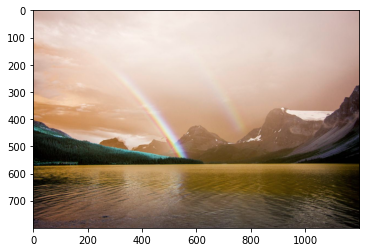

In [35]:
import matplotlib.pyplot as plt

plt.imshow(x)

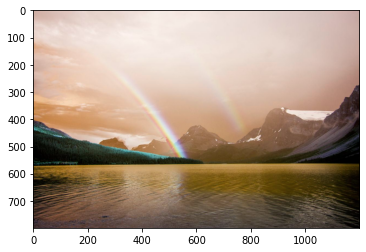

In [36]:
plt.imshow(x[1:, 1:])

## Cluster Solution
To handle duplicate images, we need a more robust solution. As outlined above, the first step is to create clusters out of the input images.

For a demo purpose, I am using a short video clip of a river scenery. On this particular day, I was lucky enough to witness a double rainbow hung along the Han River in Seoul just when the sun was going down. The video clip will show both the double rainbow and the sunset in a single take. What I expect is that there should be two clusters. The first is about the double rainbow and the second the sunset. Let's see if the clustering algorithm can do that. 
Now let's see how 

### Sample images

Let's download the demo clip and extract frame images.

In [37]:
!pip install -q youtube-dl

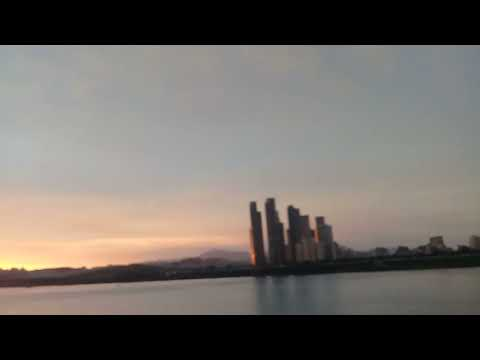

In [38]:
from IPython.display import YouTubeVideo

rainbow_sunset = "rainbow_sunset"
rainbow_sunset_id = 'I1wDZICq8XY'
YouTubeVideo(rainbow_sunset_id)

In [39]:
def download_youtube(youtube_id, save_filename):
  !youtube-dl -f 'bestvideo[ext=mp4]' --output $save_filename".%(ext)s" https://www.youtube.com/watch?v=$youtube_id

download_youtube(rainbow_sunset_id, rainbow_sunset)

[youtube] I1wDZICq8XY: Downloading webpage
[youtube] I1wDZICq8XY: Downloading MPD manifest
[download] rainbow_sunset.mp4 has already been downloaded
[download] 100% of 1.26MiB


In [40]:
def to_images(youtube_id, save_folder):
  !test -d $save_folder && rm $save_folder/*
  !mkdir $save_folder
  !ffmpeg -i $youtube_id".mp4" -filter:v fps=10 $save_folder/out%05d.jpg

to_images(rainbow_sunset, rainbow_sunset)

mkdir: cannot create directory ‘rainbow_sunset’: File exists
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --

### Extract feature maps

In [41]:
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [42]:
"""
Methods for loading and visualizing images
"""

IMAGE_SIZE = 320

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
    files = glob_files(path, file_type)

    images = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # normalize
            image = image / 256
            images.append(image)
        else:
            print(file, ' is not an image file')

    return np.array(images)

def plot_images(X, idx=None, limit=10):
  fig = plt.figure(figsize=(50,60))

  # The number of images for plotting is limited to 50
  end_id = len(X) if len(X) < limit else limit
  if idx is None:
    idx = range(0, end_id)

  i = 0
  for id in idx:
    axis = fig.add_subplot(5, 5, i+1)
    plt.axis('off')
    image = X[id]
    plt.imshow(image)
    i += 1

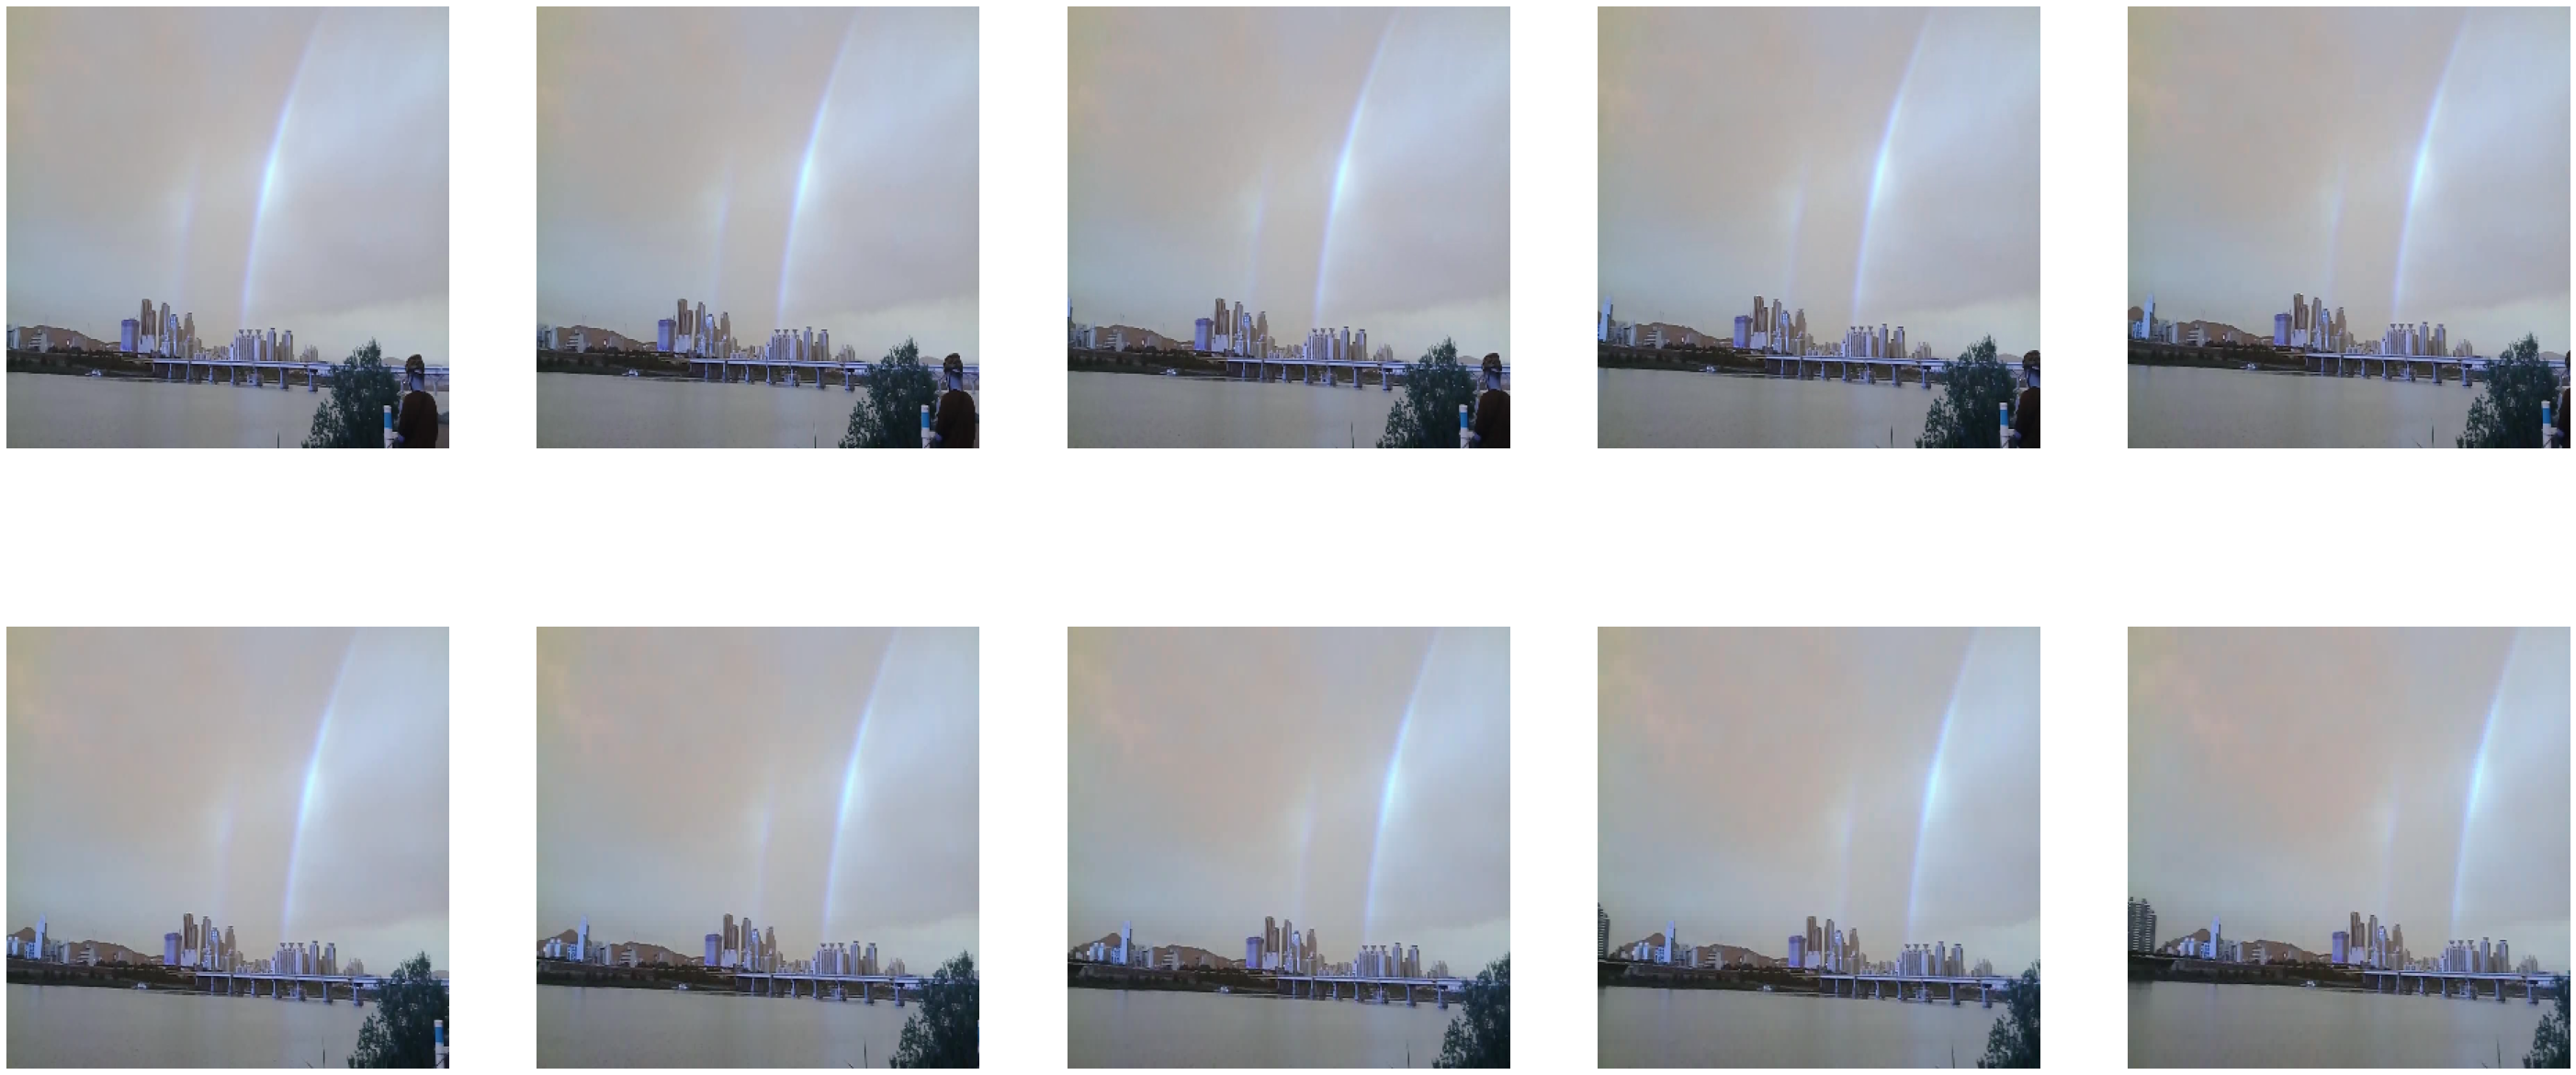

In [43]:
images = load_images(rainbow_sunset)
images.shape
plot_images(images, limit=10)

## Cluster images

In [44]:
def to_feature_maps(X, file_type="*"):
  #Convert to VGG input format
  # This is not necessary since the input is already normalized when loading
  # X_processed = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  return model.predict(X)

def get_pca_reduced(X_fm, dimensions=2):
  X_fm_flat = X_fm.reshape(X_fm.shape[0], -1)
  pca = PCA(dimensions)

  X_fm_reduced = pca.fit_transform(X_fm_flat)

  return X_fm_reduced, pca


def get_clusters(X, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(X, K=2):
  # make it 2D
  X_reshaped = preprocessing.normalize(X.reshape(len(X), -1))
  X_clusters, kmeans = get_clusters(X_reshaped, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  # return X_reshaped, kmeans
  return X_reshaped, X_clusters, kmeans

def cluster_images_fm(X, K=2, cosine_distance=True):
  X_fm = to_feature_maps(X)

  # # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  X_clusters_fm, kmeans_fm = get_clusters(X_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_fm, X_clusters_fm, kmeans_fm


In [45]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("K-means clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

Having defined all the necessary methods, we can simply call cluster_images to get the clusters.

I am using two different cluster methods. The first method cluster_images() uses simple pixel values to get clusters. The second method cluster_images_fm() extract feature maps to cluster.

In [46]:
X = load_images(rainbow_sunset)

X_reshaped, X_clusters, kmeans = cluster_images(X)

[[0.00180476 0.00186183 0.00188041 ... 0.00079254 0.00096068 0.00138107]
 [0.00198384 0.0019629  0.00188658 ... 0.00086894 0.00091189 0.0009721 ]]
{0: array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}


### Let's do PCA for visualization
To visualize the clusters, let's do PCA and re-cluster them. The results are identical to the original cluster.

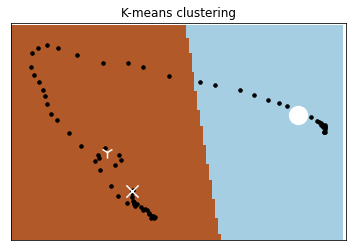

In [47]:
K = 2
# Let's do PCA for visualization
X_reduced, pca = get_pca_reduced(X_reshaped, dimensions=K)
X_clusters_reduced, kmeans_reduced = get_clusters(X_reduced, K)
plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])

In [48]:
X_clusters.cluster_centers_

array([[0.00180476, 0.00186183, 0.00188041, ..., 0.00079254, 0.00096068,
        0.00138107],
       [0.00198384, 0.0019629 , 0.00188658, ..., 0.00086894, 0.00091189,
        0.0009721 ]])

## Cluster using feature maps

Let's also cluster feature maps as a comparison.

In [54]:
X = load_images(rainbow_sunset)
X_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(X)

[[9.6063863e-04 0.0000000e+00 0.0000000e+00 ... 5.8207661e-11
  4.7153803e-03 0.0000000e+00]
 [1.1098559e-03 0.0000000e+00 0.0000000e+00 ... 2.8409471e-04
  5.4307333e-03 0.0000000e+00]]
{0: array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}


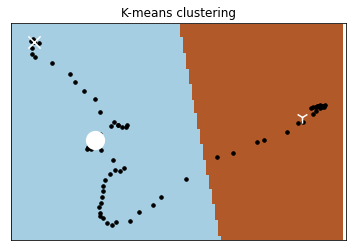

In [56]:
# Let's do PCA for visualization
X_reduced_fm, pca_fm = get_pca_reduced(X_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced_fm, K)
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm, idx=[1])

In [57]:
X_clusters_reduced.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [58]:
X_clusters.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [59]:
X_clusters_fm.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [60]:
X_clusters.cluster_centers_

array([[0.00180476, 0.00186183, 0.00188041, ..., 0.00079254, 0.00096068,
        0.00138107],
       [0.00198384, 0.0019629 , 0.00188658, ..., 0.00086894, 0.00091189,
        0.0009721 ]])

In [61]:
X_clusters_fm.cluster_centers_

array([[9.6063863e-04, 0.0000000e+00, 0.0000000e+00, ..., 5.8207661e-11,
        4.7153803e-03, 0.0000000e+00],
       [1.1098559e-03, 0.0000000e+00, 0.0000000e+00, ..., 2.8409471e-04,
        5.4307333e-03, 0.0000000e+00]], dtype=float32)

The results are quite similar and we can see two clusters are formed as expected.

## Save the centroids
Now let's save the two centroids for later processing.

In [62]:
import json

def to_json(path, data):
    """
    save json data to path
    """
    with open(path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

def from_json(path):
    """
    save json data to path
    """
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

Let's use the feature map version of the clusters.

In [63]:
centroids_filename = 'centroids.json'
to_json(centroids_filename, kmeans_fm.cluster_centers_.tolist())
print('centroid values are saved as {}'.format(centroids_filename))

centroid values are saved as centroids.json


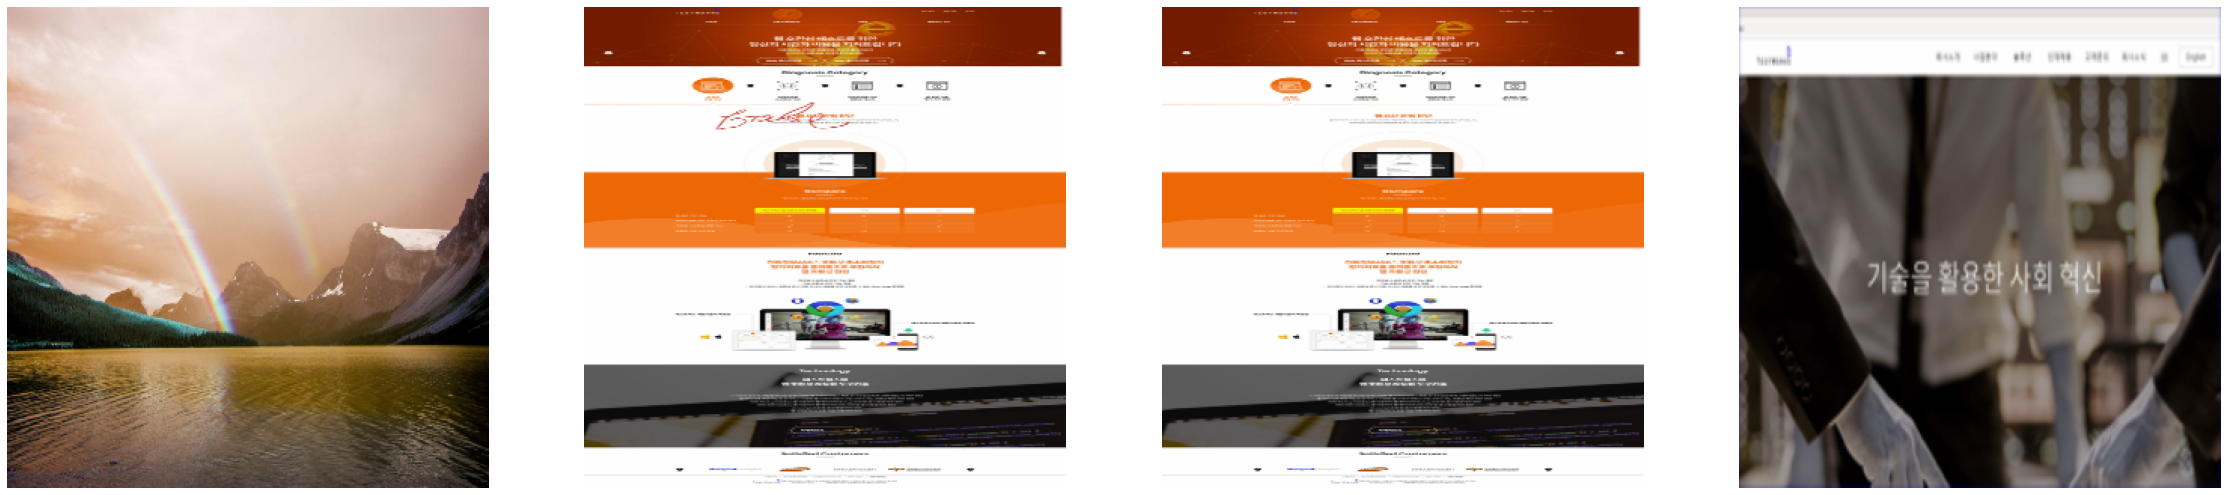

In [65]:
X_test = load_images('/content/ClassifyImages/data/test')
plot_images(X_test)

X_test_fm = to_feature_maps(X_test)

In [66]:
X_test_fm.shape

X_test_fm = preprocessing.normalize(X_test_fm.reshape(len(X_test_fm), -1))


## Calculate distances

In [68]:
def find_min_max(X_data):
  # Calculate distances of all points
  distances = cdist(X_data, X_data)

  rows = distances.shape[0]

  max_id1 = int(np.argmax(distances)/rows)
  max_id2 = np.argmax(distances[max_id1])

  # use the max value to set the zero value of the diagonal 
  max = np.max(distances)

  for row_id in range(distances.shape[0]):
    distances[row_id, row_id] = max

  min_id1 = int(np.argmin(distances)/distances.shape[0])
  min_id2 = np.argmin(distances[min_id1])

  print("min: {} {}".format((min_id1, min_id2), distances[min_id1, min_id2]))
  print("max: {} {}".format((max_id1, max_id2), distances[max_id1, max_id2]))

  return (min_id1, min_id2), (max_id1, max_id2)

In [69]:
(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_fm)

min: (63, 64) 0.04272963502608025
max: (0, 64) 0.3879900442191612


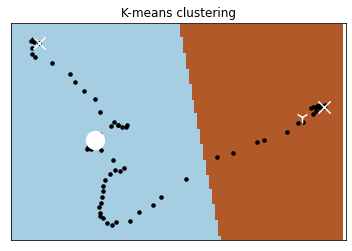

In [71]:
plot_data_in_clusters(X_reduced_fm, kmeans_reduced_fm, idx=[0, 64])

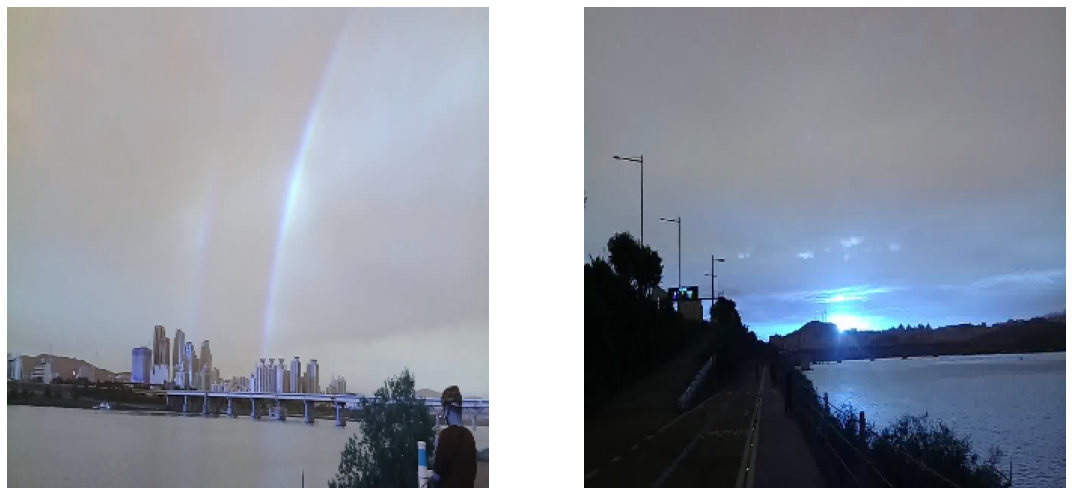

In [72]:
plot_images(X, idx=[0, 64])

In [75]:
(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_reshaped)

min: (63, 64) 0.050592822321409915
max: (42, 64) 0.5675713706263043


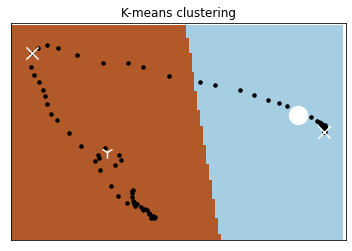

In [76]:
plot_data_in_clusters(X_reduced, kmeans_reduced, idx=[42, 64])

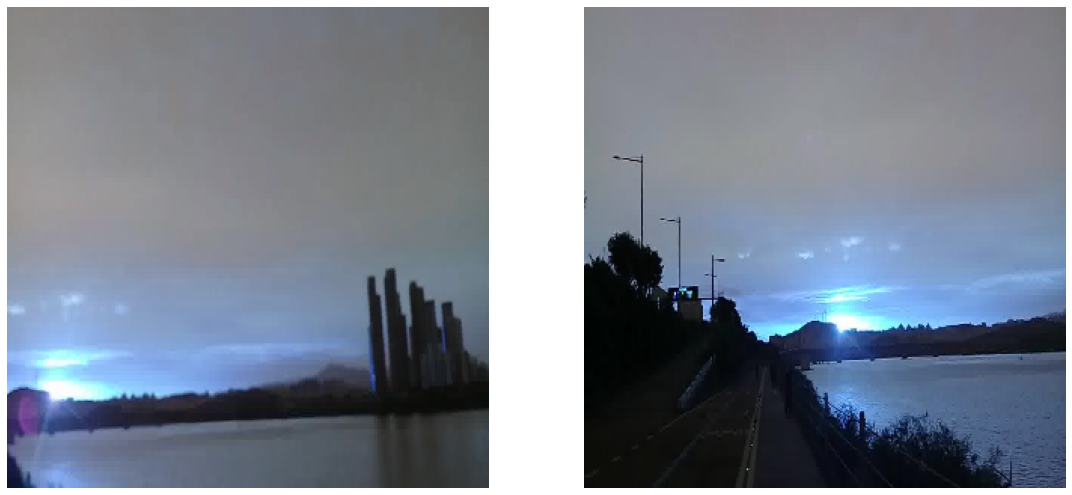

In [77]:
plot_images(X, idx=[42, 64])

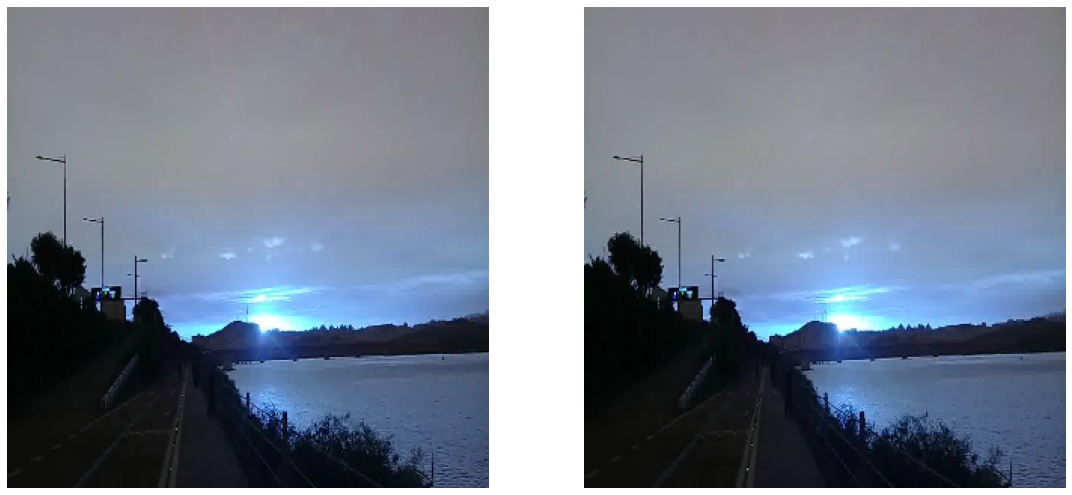

In [73]:
plot_images(X, idx=[63, 64])

In [81]:
X_test_reshaped = preprocessing.normalize(X_test.reshape(len(X_test), -1))
cdist([X_test_reshaped[0], X_clusters_fm.cluster_centers_], [X_test_reshaped[0], X_clusters_fm.cluster_centers_])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

In [83]:
X_clusters_fm.cluster_centers_.shape

(2, 51200)

In [85]:
X_test_reshaped.shape

(4, 307200)

In [87]:
X.shape

(73, 320, 320, 3)

In [86]:
X_test.shape

(4, 320, 320, 3)

In [89]:
preprocessing.normalize(X_test.reshape(len(X_test), -1)).shape

(4, 307200)

In [90]:
X.shape

(73, 320, 320, 3)

In [91]:
preprocessing.normalize(X.reshape(len(X), -1)).shape

(73, 307200)

In [93]:
X_clusters.cluster_centers_.shape

(2, 307200)

In [94]:
X_clusters_fm.cluster_centers_.shape

(2, 51200)

In [106]:
nd_compare = np.vstack((X_clusters.cluster_centers_, X_test_reshaped))
nd_compare.shape


(6, 307200)

In [108]:
find_min_max(nd_compare)

min: (3, 4) 0.02472520927529764
max: (4, 5) 0.8854602475347778


((3, 4), (4, 5))

In [109]:
cdist(nd_compare, nd_compare)

array([[0.        , 0.34722591, 0.45873775, 0.65815306, 0.65747026,
        0.66353403],
       [0.34722591, 0.        , 0.38017391, 0.4919745 , 0.49147008,
        0.64532598],
       [0.45873775, 0.38017391, 0.        , 0.64965454, 0.64862952,
        0.60791395],
       [0.65815306, 0.4919745 , 0.64965454, 0.        , 0.02472521,
        0.88539092],
       [0.65747026, 0.49147008, 0.64862952, 0.02472521, 0.        ,
        0.88546025],
       [0.66353403, 0.64532598, 0.60791395, 0.88539092, 0.88546025,
        0.        ]])

In [113]:
dist = np.linalg.norm(X_clusters.cluster_centers_ - X_test_reshaped[0], ord=2, axis=1)

In [117]:
np.linalg.norm(X_clusters.cluster_centers_ - X_test_reshaped[1], ord=2, axis=1)

array([0.65815306, 0.4919745 ])

In [118]:
np.linalg.norm(X_clusters.cluster_centers_ - X_test_reshaped[2], ord=2, axis=1)

array([0.65747026, 0.49147008])

In [120]:
np.linalg.norm(X_clusters.cluster_centers_ - X_reshaped[50], ord=2, axis=1)

array([0.3210726 , 0.26390798])

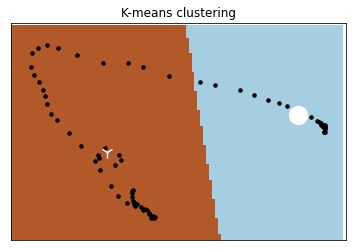

In [116]:
plot_data_in_clusters(X_reduced, kmeans_reduced)

## A new video - migrating birds
Now let's process a new set of images. This video clip is about a flock of migrating birds.

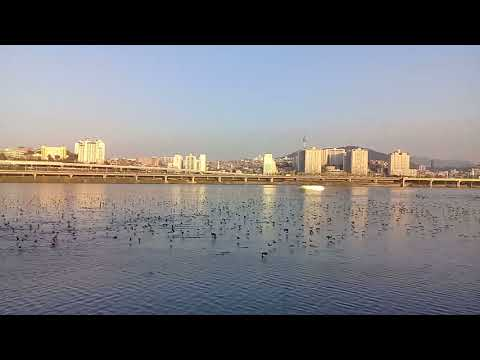

In [121]:
migrating_birds = "migrating_birds"
migrating_birds_id = '-0jhgfyzINQ'
YouTubeVideo(migrating_birds_id)

In [122]:
download_youtube(migrating_birds_id, migrating_birds)
to_images(migrating_birds, migrating_birds)

[youtube] -0jhgfyzINQ: Downloading webpage
[youtube] -0jhgfyzINQ: Downloading MPD manifest
[download] migrating_birds.mp4 has already been downloaded
[download] 100% of 2.36MiB
mkdir: cannot create directory ‘migrating_birds’: File exists
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --ena

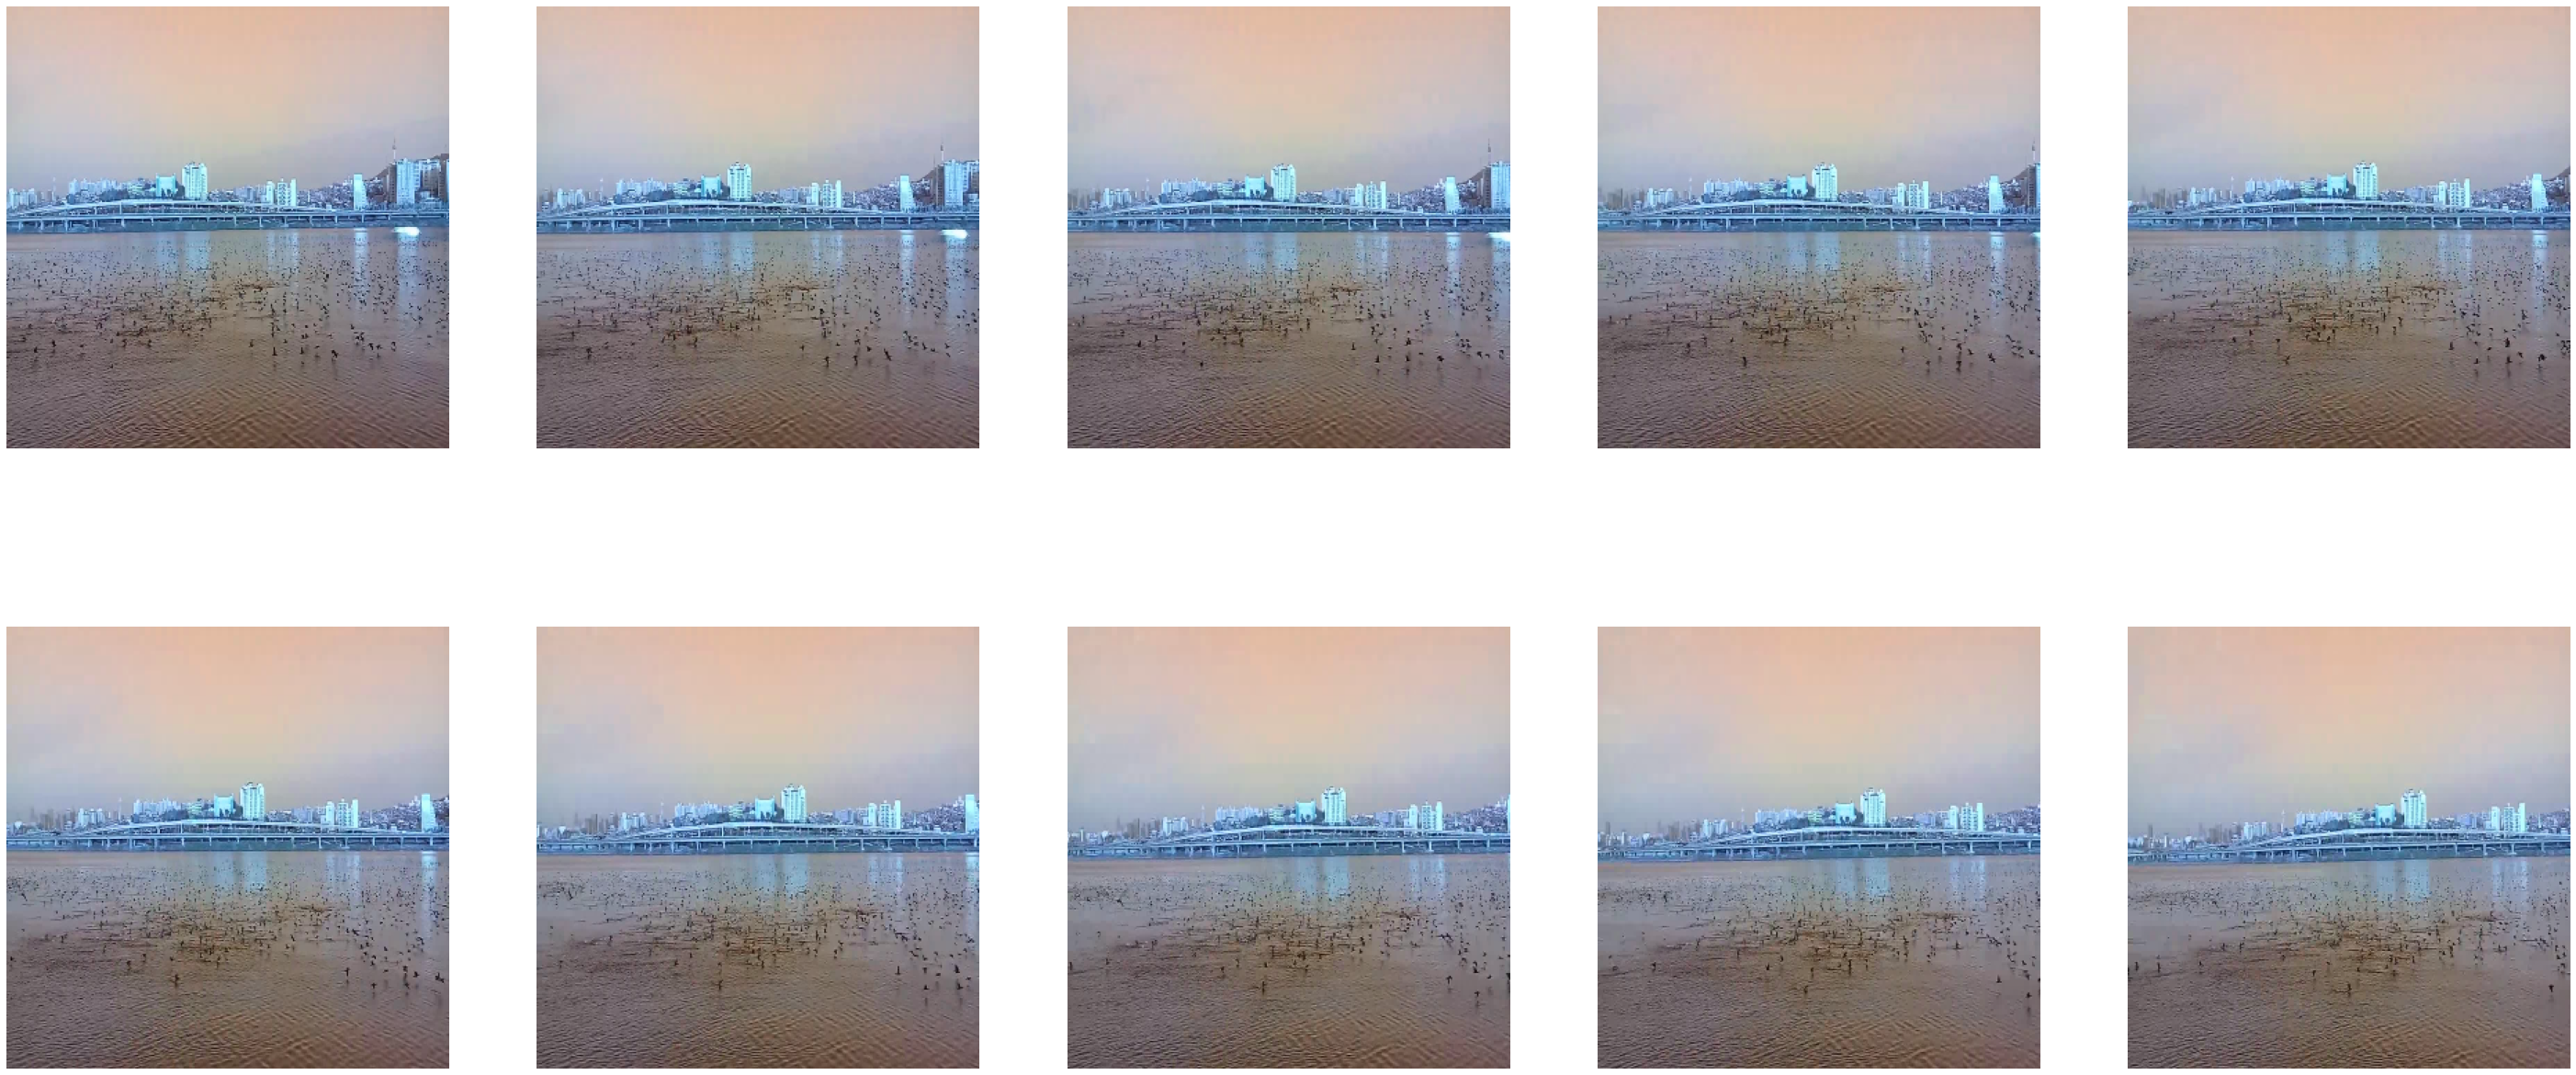

In [124]:
X_mb = load_images(migrating_birds)
X_mb.shape
plot_images(X_mb, limit=10)

In [129]:
X_mb_fm = to_feature_maps(X_mb)


X_mb_reshaped_fm = preprocessing.normalize(X_mb_fm.reshape(len(X_mb_fm), -1))

In [144]:
idx = to_cluster_idx(X_clusters_fm.labels_, range(K))

In [151]:
def get_cluster_data(X, idx):
  return np.array([X[id] for id in idx])

X_cluster_data0 = get_cluster_data(X_fm, idx[0])
X_cluster_data1 = get_cluster_data(X_fm, idx[1])

In [157]:
distances0 = np.linalg.norm(X_cluster_data0 - X_mb_reshaped_fm[0], ord=2, axis=1)

In [154]:
distances1 = np.linalg.norm(X_cluster_data1 - X_mb_reshaped_fm[0], ord=2, axis=1)

In [158]:
np.min(distances0)

0.42321464

In [156]:
np.min(distances1)

0.40894055

In [134]:
X_test_fm = to_feature_maps(X_test)

X_test_reshaped_fm = preprocessing.normalize(X_test_fm.reshape(len(X_test_fm), -1))

In [130]:
np.linalg.norm(X_clusters_fm.cluster_centers_ - X_mb_reshaped_fm[0], ord=2, axis=1)

array([0.41895488, 0.3913977 ], dtype=float32)

In [138]:
np.linalg.norm(X_clusters_fm.cluster_centers_ - X_mb_reshaped_fm[95], ord=2, axis=1)

array([0.40950987, 0.38602898], dtype=float32)

In [136]:
np.linalg.norm(X_clusters_fm.cluster_centers_ - X_test_reshaped_fm[0], ord=2, axis=1)

array([0.4173012, 0.3990866], dtype=float32)

In [139]:
np.linalg.norm(X_clusters_fm.cluster_centers_ - X_test_reshaped_fm[1], ord=2, axis=1)

array([0.55226797, 0.52435696], dtype=float32)

In [141]:
np.linalg.norm(X_fm - X_mb_reshaped_fm[0], ord=2, axis=1)

array([0.47756952, 0.47195387, 0.46726707, 0.46183297, 0.463088  ,
       0.46133286, 0.46008915, 0.45894992, 0.45941105, 0.45509464,
       0.4484521 , 0.44438422, 0.4463936 , 0.4471616 , 0.44109774,
       0.43974957, 0.43572778, 0.43974113, 0.43957576, 0.43127966,
       0.43644452, 0.43350214, 0.4329776 , 0.43234625, 0.4373464 ,
       0.43307298, 0.4289298 , 0.4263913 , 0.42696738, 0.41539565,
       0.41088212, 0.4167347 , 0.42079458, 0.41738912, 0.41850257,
       0.41911337, 0.4159847 , 0.41401154, 0.4113344 , 0.40894055,
       0.40994152, 0.40941665, 0.4122402 , 0.4117987 , 0.41313028,
       0.41501945, 0.41478395, 0.4167098 , 0.4208626 , 0.42603576,
       0.4323433 , 0.42321464, 0.4270063 , 0.42820436, 0.42489678,
       0.42829275, 0.4318362 , 0.43184862, 0.43483773, 0.43427837,
       0.4343679 , 0.43498603, 0.43328327, 0.43484294, 0.4339437 ,
       0.43298745, 0.4324606 , 0.43173525, 0.43490496, 0.4326514 ,
       0.4319075 , 0.4339636 , 0.43409523], dtype=float32)

In [142]:
np.linalg.norm(X_fm - X_fm[50], ord=2, axis=1)

array([0.36435106, 0.35985988, 0.35144088, 0.3416994 , 0.33910987,
       0.3357662 , 0.33247206, 0.3304147 , 0.33069426, 0.32081482,
       0.31114778, 0.30651435, 0.30293655, 0.30135772, 0.28993997,
       0.28222317, 0.28102815, 0.28396425, 0.28722322, 0.28022   ,
       0.28372747, 0.28252223, 0.28019223, 0.27426004, 0.2834205 ,
       0.28406417, 0.27708143, 0.28067464, 0.28538844, 0.2726655 ,
       0.27463275, 0.28157437, 0.282898  , 0.28016385, 0.2871928 ,
       0.28887743, 0.28769308, 0.2907445 , 0.29023683, 0.29272452,
       0.28877506, 0.28694874, 0.2867052 , 0.27879786, 0.26873222,
       0.24903274, 0.22893406, 0.2037921 , 0.16781312, 0.13419643,
       0.        , 0.15437882, 0.17242004, 0.19946513, 0.20302536,
       0.23129565, 0.2458639 , 0.2516816 , 0.26411617, 0.2716013 ,
       0.28054246, 0.2760114 , 0.2891108 , 0.29601112, 0.29388472,
       0.29378664, 0.28784543, 0.2862694 , 0.28650752, 0.28485864,
       0.2875428 , 0.2812466 , 0.2874548 ], dtype=float32)

In [162]:

def find_duplicates(X_train_pca, threshold=0.1):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca)

    # Find duplicates (very similar images)
    # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
    dupes = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    to_remove = set()
    for d in dupes:
        if len(d) > 1:
            for id in range(1, len(d)):
                to_remove.add(d[id])
    print("Found {} duplicates".format(len(to_remove)))
    return to_remove

In [226]:
to_remove = find_duplicates(X_reshaped)

Found 20 duplicates


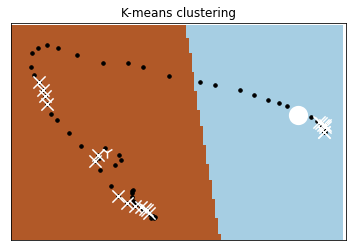

In [228]:
plot_data_in_clusters(X_reduced, kmeans_reduced, idx=to_remove)

In [229]:
to_remove_fm = find_duplicates(X_reduced_fm, threshold=0.022)

Found 67 duplicates


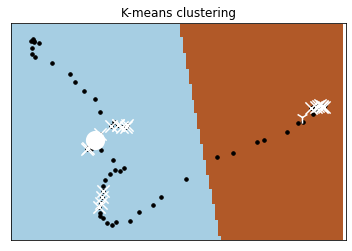

In [230]:
plot_data_in_clusters(X_reduced_fm, kmeans_reduced_fm, idx=list(to_remove))

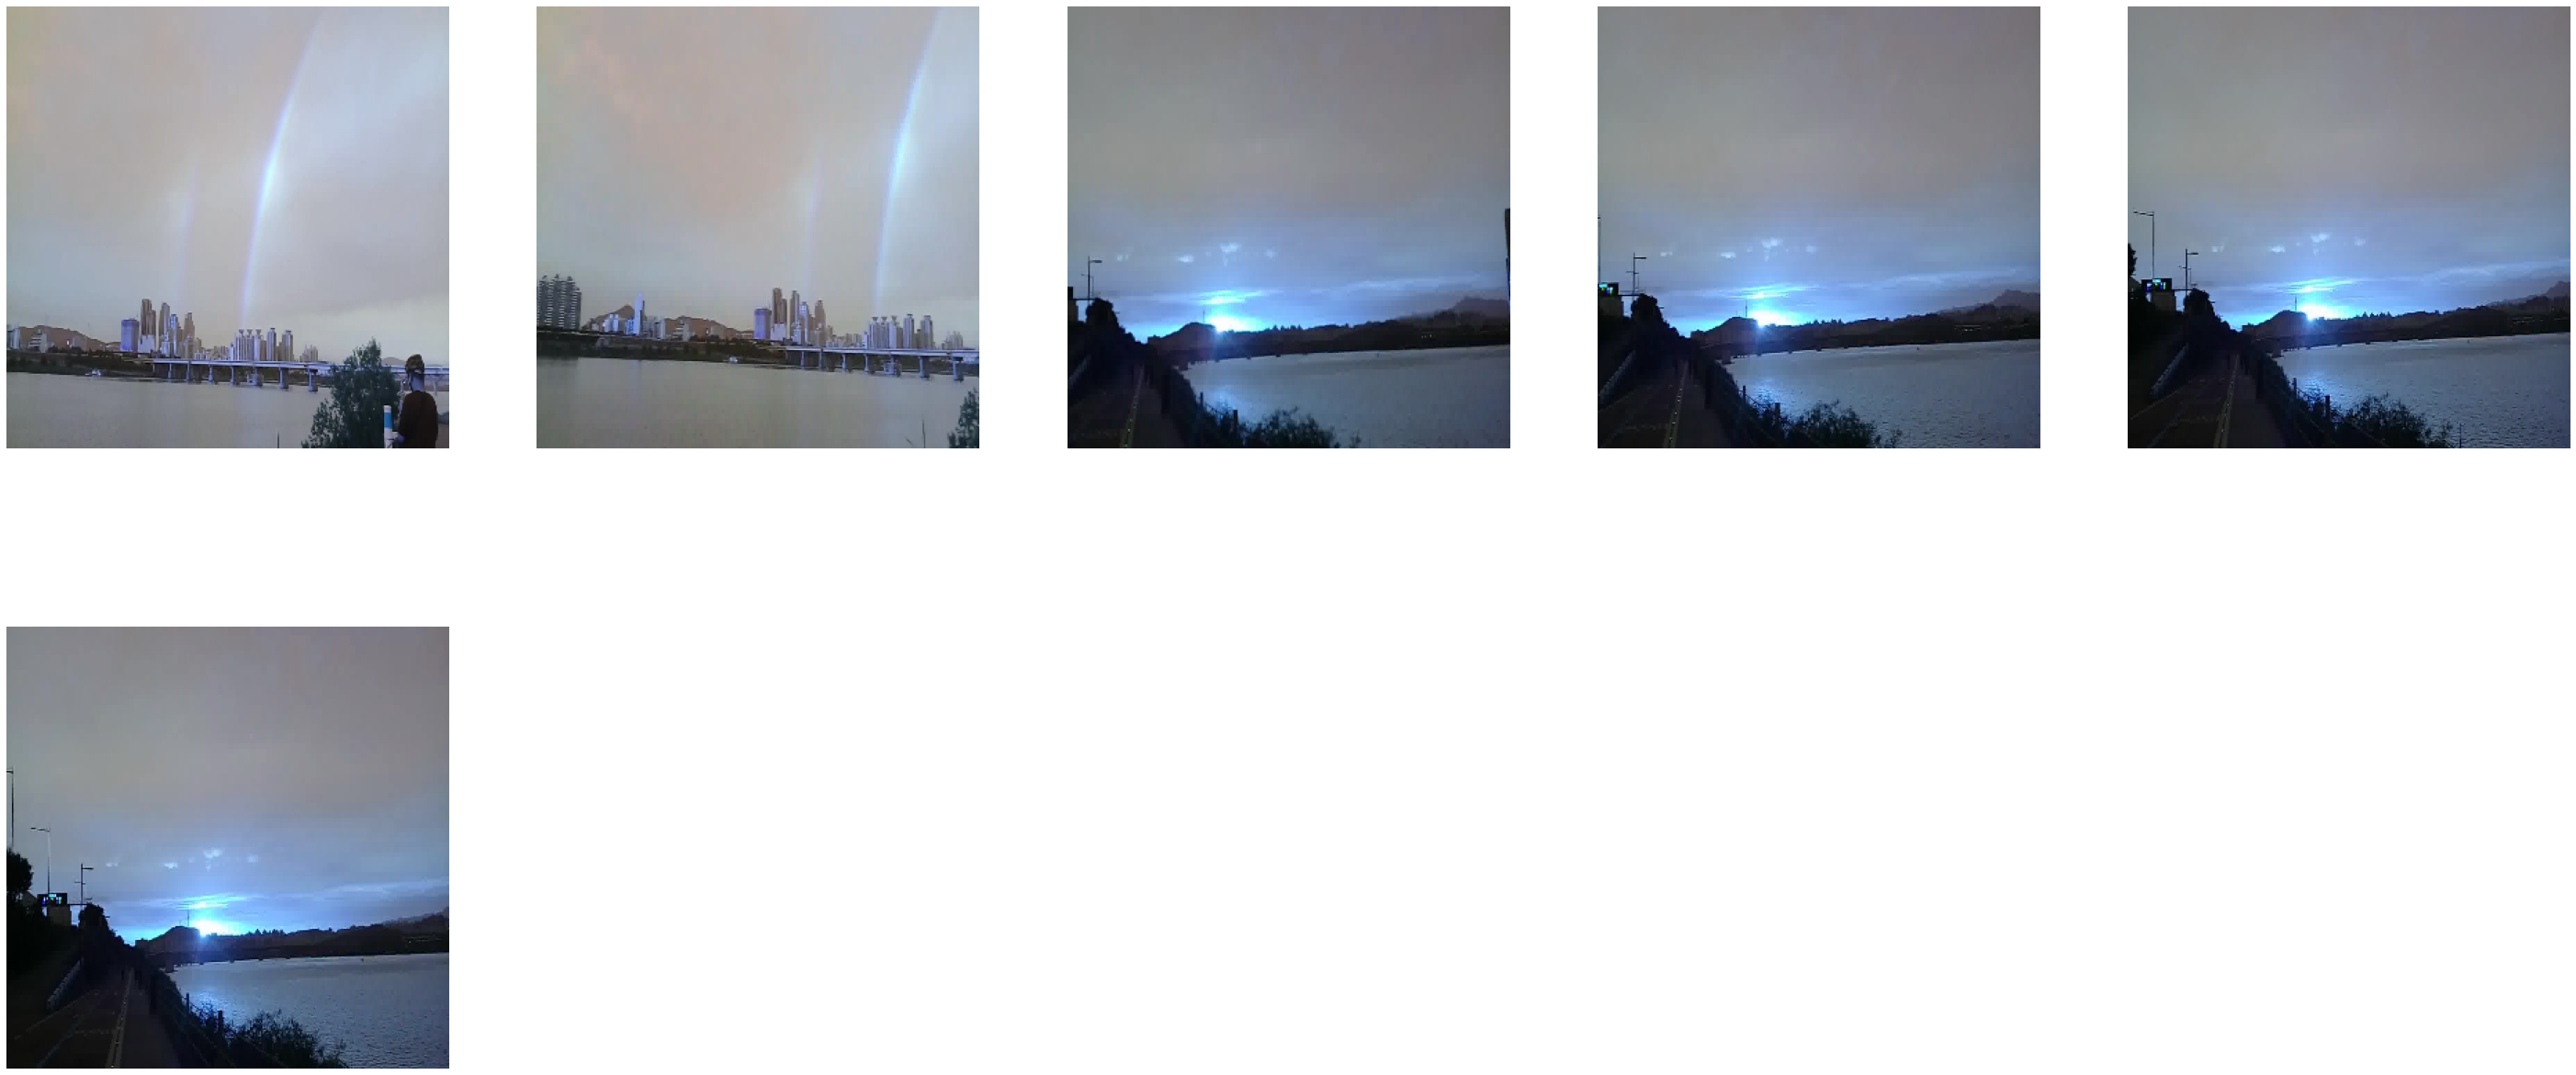

In [225]:
to_keep = [id not in to_remove for id in range(X.shape[0])]

plot_images(X[to_keep])